In [2]:
#basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#stationarity test
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler


#time-series prediction models
#from statsmodels.tsa.ar_model import AR
#from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#trend analysis
from sklearn.linear_model import LinearRegression

#to generate all combinations of the parameters
import itertools

#models' accuracy calculation
from sklearn.metrics import mean_squared_error

#to ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/DJIA_table.csv')


In [4]:
df['DiffPrice'] = df['Close']-df['Open']

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,DiffPrice
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,25.128907
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,217.230468
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,238.660157
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,219.210937
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-214.970704


In [6]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close,DiffPrice
count,1989.000000,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000,1989.000000
mean,13459.116048,13541.303173,13372.931728,13463.032255,1.628110e+08,13463.032255,3.916206
std,3143.281634,3136.271725,3150.420934,3144.006996,9.392343e+07,3144.006996,141.227938
min,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06,6547.049805,-774.169922
25%,10907.339844,11000.980469,10824.759766,10913.379883,1.000000e+08,10913.379883,-60.169922
50%,13022.049805,13088.110352,12953.129883,13025.580078,1.351700e+08,13025.580078,8.540039
75%,16477.699219,16550.070312,16392.769531,16478.410156,1.926000e+08,16478.410156,74.558594
max,18315.060547,18351.359375,18272.560547,18312.390625,6.749200e+08,18312.390625,925.190430


In [7]:
data = df
data = data.set_index('Date')
data = data.loc[:,'Close']

<AxesSubplot:xlabel='Date'>

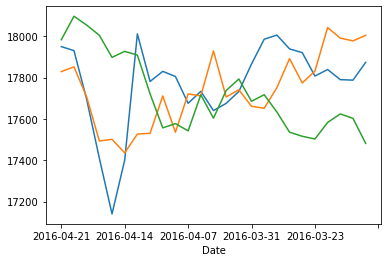

In [28]:
data[0:25].plot()
data[25:50].plot()
data[50:75].plot()

In [9]:
data.describe()

count     1989.000000
mean     13463.032255
std       3144.006996
min       6547.049805
25%      10913.379883
50%      13025.580078
75%      16478.410156
max      18312.390625
Name: Close, dtype: float64

Text(0.5, 1.0, 'Autocorrelation plot lag=5')

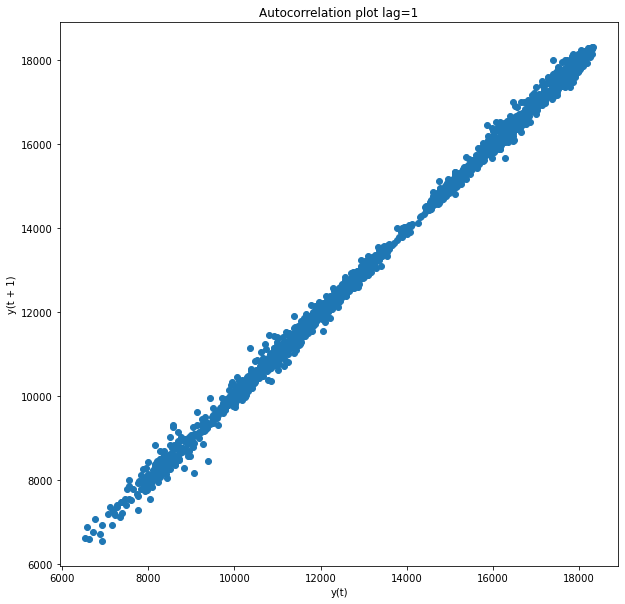

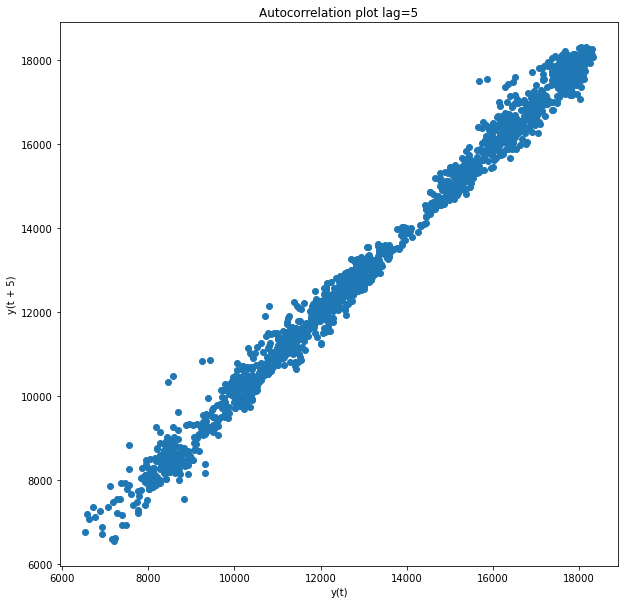

In [10]:
from pandas.plotting import lag_plot
plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=1)
plt.title('Autocorrelation plot lag=1')

plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=5)
plt.title('Autocorrelation plot lag=5')


In [11]:

import matplotlib.pyplot as plt

In [12]:
#stationarity test
from statsmodels.tsa.stattools import adfuller

In [13]:
result = adfuller(data)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -1.226757785411685
p-value: 0.6619805931301762


In [14]:
data_price_diff = df
data_price_diff = data_price_diff.set_index('Date')
data_price_diff =  data_price_diff.loc[:,'DiffPrice']

<AxesSubplot:xlabel='Date'>

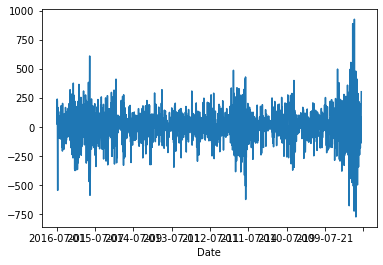

In [15]:
#Differencing
data_price_diff.plot()

In [16]:
result = adfuller(data_price_diff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -10.090028744927771
p-value: 1.1285560565967265e-17


# AR Model

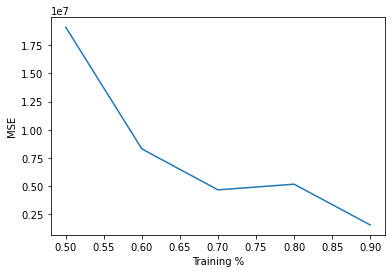

In [17]:
#plot the accuracy with various train-test splits

x = data.values

train_per_list=[0.5,0.6,0.7,0.8,0.9]
acc_list=[]

for train_per in train_per_list:
    
    #perform the split
    train = x[:int(x.size*train_per)]
    test = x[int(x.size*train_per):]
    
    #train the model
    arma_model = ARIMA(train, order=(1, 0, 1))
    arma_fit = arma_model.fit()
    arma_pred = arma_fit.predict(start=int(x.size*train_per), end=x.size-1)
    
    #store the results
    acc_list.append(mean_squared_error(test, arma_pred))

#plot the graph
plt.plot(train_per_list,acc_list)
plt.ylabel('MSE')
plt.xlabel('Training %')
plt.show()

In [18]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x = np.array(data.values)
x = x.reshape(-1,1)
x = min_max_scaler.fit_transform(x)

In [19]:
p = [1,5,7,10,12,15,20]
d = range(0,5)
q = [1,5,7]

pdq = list(itertools.product(p,d,q))

acc_list = []

smallest_mse = 1000000000000000
train_per_list=[0.7]

best=[]
for train_per in train_per_list:
    i=1
    train = x[:int(x.size*train_per)]
    test = x[int(x.size*train_per):]    
    for param in pdq:
        i+=1

        try:
            #train the model 
            arima_model = ARIMA(train, order=param)
            arima_fit = arima_model.fit()

            #record the predictions for calculating accuracy
            arima_pred = arima_fit.predict(start=int(x.size*train_per), end=x.size-1)
            acc=mean_squared_error(test, arima_pred)

            #store the accrucy in a list for graph plotting
            acc_list.append([train_per,param,acc])

            #capture the smallest MSE and its parameters
            if acc < smallest_mse:
                smallest_mse = acc
                best = [param, train_per]
            print("For ",train_per," executed : ",i,"/",len(pdq)," : ", param, "MSE ",acc)    

        except:
            #if the parameters are invalid, i.e. model training gives error, 
            #then add a very high error rate in the accrucy list
            print('Error in training model with param',param)
            acc_list.append([train_per,param,1])
            continue
        

print(acc_list)
print("\n\nsmallest mse is ", smallest_mse)
print("best parameters are ", best)


For  0.7  executed :  2 / 105  :  (1, 0, 1) MSE  0.07028560460955069
For  0.7  executed :  3 / 105  :  (1, 0, 5) MSE  0.060378537217107404
For  0.7  executed :  4 / 105  :  (1, 0, 7) MSE  0.061648830203514964
For  0.7  executed :  5 / 105  :  (1, 1, 1) MSE  0.08440381041469427
For  0.7  executed :  6 / 105  :  (1, 1, 5) MSE  0.08440060693792219
For  0.7  executed :  7 / 105  :  (1, 1, 7) MSE  0.08440090606887812
For  0.7  executed :  8 / 105  :  (1, 2, 1) MSE  0.08418821329055573
For  0.7  executed :  10 / 105  :  (1, 2, 7) MSE  0.08418801936632112
For  0.7  executed :  17 / 105  :  (5, 0, 1) MSE  0.060849313394806134
For  0.7  executed :  18 / 105  :  (5, 0, 5) MSE  0.06148448192840471
For  0.7  executed :  19 / 105  :  (5, 0, 7) MSE  0.03735811945602793
For  0.7  executed :  20 / 105  :  (5, 1, 1) MSE  0.08440094368250234
For  0.7  executed :  21 / 105  :  (5, 1, 5) MSE  0.0843980732956506
For  0.7  executed :  22 / 105  :  (5, 1, 7) MSE  0.08438751272656442
For  0.7  executed :  23 

In [22]:
p=[1,2,3]
x=p.copy()
x.append(4)
print(p,x)

[1, 2, 3] [1, 2, 3, 4]


In [ ]:
#model building + training
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit()
sarima_pred = sarima_fit.forecast(steps=(x.size-int(x.size*train_per)))

#accuracy and predictions display
print("MSE : ",mean_squared_error(test, sarima_pred))

In [ ]:
p = range(1,70,10)
d = range(0,5)
q = range(1,70,10)

pdq = list(itertools.product(p,d,q))

acc_list = []

smallest_mse = 1000000000000000
train_per_list=[0.5,0.6,0.7,0.8]

best=[]
for train_per in train_per_list:
    i=1
    train = x[:int(x.size*train_per)]
    test = x[int(x.size*train_per):]    
    for param in pdq:
        i+=1

        try:
            seasonal_order = param
            seasonal_order.append(1)
            
            #train the model 
            sarima_model = SARIMAX(train, order=param, seasonal_order=seasonal_order)
            arima_fit = arima_model.fit()

            #record the predictions for calculating accuracy
            arima_pred = arima_fit.predict(start=int(x.size*train_per), end=x.size-1)
            acc=mean_squared_error(test, arima_pred)

            #store the accrucy in a list for graph plotting
            acc_list.append(acc)

            #capture the smallest MSE and its parameters
            if acc < smallest_mse:
                smallest_mse = acc
                best = [param, train_per]
            print("For ",train_per," executing : ",i,"/",len(pdq)," : ", param, "MSE ",acc)    

        except:
            #if the parameters are invalid, i.e. model training gives error, 
            #then add a very high error rate in the accrucy list
            acc_list.append(100000)
            continue
        
print("\n\nsmallest mse is ", smallest_mse)
print("best parameters are ", best)